In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sales_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AI in Marketing Dataset/sales_data_sample.csv', encoding = 'unicode_escape')
# Note: MSRP is the manufacturer's suggested retail price (MSRP) or sticker price represents the suggested retail price of products.
# MSRP is used to standardize the price of products over multiple company store locations.

In [ ]:
sales_df.head(2)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.0,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.9,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small


In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [ ]:
sales_df.dtypes

,0
ORDERNUMBER,int64
QUANTITYORDERED,int64
PRICEEACH,float64
ORDERLINENUMBER,int64
SALES,float64
ORDERDATE,object
STATUS,object
QTR_ID,int64
MONTH_ID,int64
YEAR_ID,int64


In [ ]:
sales_df['ORDERDATE']= pd.to_datetime(sales_df['ORDERDATE'])
sales_df['ORDERDATE'].dtypes

dtype('<M8[ns]')

In [ ]:
# Check the number of non-null values in the dataframe
sales_df.info()

# Check the number of Null values in the data
sales_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

,0
ORDERNUMBER,0
QUANTITYORDERED,0
PRICEEACH,0
ORDERLINENUMBER,0
SALES,0
ORDERDATE,0
STATUS,0
QTR_ID,0
MONTH_ID,0
YEAR_ID,0


In [ ]:
# since there are lot of Null values in 'addressline2', 'state', 'postal code' and 'territory' we can drop them.
# Country would represent the order grographical information.
# Also we can drop city, address1, phone number, contact_name, contact last_name and contact first_name since they are not required for the analysis

df_drop  = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df = sales_df.drop(df_drop, axis = 1)
sales_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,USA,Medium


In [ ]:
sales_df.isnull().sum()

,0
QUANTITYORDERED,0
PRICEEACH,0
ORDERLINENUMBER,0
SALES,0
ORDERDATE,0
STATUS,0
QTR_ID,0
MONTH_ID,0
YEAR_ID,0
PRODUCTLINE,0


In [ ]:
# Obtain the number of unique values in each column
sales_df.nunique()

,0
QUANTITYORDERED,58
PRICEEACH,1016
ORDERLINENUMBER,18
SALES,2763
ORDERDATE,252
STATUS,6
QTR_ID,4
MONTH_ID,12
YEAR_ID,3
PRODUCTLINE,7


In [ ]:
sales_df['COUNTRY'].value_counts().index

Index(['USA', 'Spain', 'France', 'Australia', 'UK', 'Italy', 'Finland',
       'Norway', 'Singapore', 'Canada', 'Denmark', 'Germany', 'Sweden',
       'Austria', 'Japan', 'Belgium', 'Switzerland', 'Philippines', 'Ireland'],
      dtype='object', name='COUNTRY')

In [ ]:
sales_df['COUNTRY'].value_counts()

,count
COUNTRY,
USA,1004
Spain,342
France,314
Australia,185
UK,144
Italy,113
Finland,92
Norway,85
Singapore,79


In [ ]:
# Function to visulize the count of items in a given column
# Note that Plotly is a Python graphing library that makes interactive, publication-quality graphs.
# Check it out: https://plotly.com/python/
# Note: px (plotly_express) is a high-level wrapper around plotly for rapid data exploration and figure generation
# Check this out: https://plotly.github.io/plotly_express

def barplot_visualization(x):
  fig = plt.Figure(figsize = (12, 6))
  fig = px.bar(x = sales_df[x].value_counts().index, y = sales_df[x].value_counts(), color = sales_df[x].value_counts().index, height = 600)
  fig.show()

In [ ]:
# Let's call this function for any given column such as 'COUNTRY'
barplot_visualization('COUNTRY')
#STATUS

In [ ]:
sales_df.drop(columns= ['STATUS'], inplace = True)
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,USA,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,S72_3212,Spain,Small
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,S72_3212,Finland,Medium
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,S72_3212,Spain,Medium
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,S72_3212,France,Small


In [ ]:
 # Function to add dummy variables to replace categorical variables

def dummies(x):
  dummy = pd.get_dummies(sales_df[x],dtype=int)
  sales_df.drop(columns = x , inplace = True)
  return pd.concat([sales_df, dummy], axis = 1)

In [ ]:
# Let's obtain dummy variables for the column 'COUNTRY'
sales_df = dummies('COUNTRY')
sales_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,...,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
sales_df.dtypes

,0
QUANTITYORDERED,int64
PRICEEACH,float64
ORDERLINENUMBER,int64
SALES,float64
ORDERDATE,datetime64[ns]
QTR_ID,int64
MONTH_ID,int64
YEAR_ID,int64
PRODUCTLINE,object
MSRP,int64


In [ ]:
sales_df = dummies('PRODUCTLINE')
sales_df.head(3)

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,...,0,0,1,0,1,0,0,0,0,0
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,...,0,0,0,0,1,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
sales_df = dummies('DEALSIZE')

In [ ]:
y = pd.Categorical(sales_df['PRODUCTCODE'])
y


['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962',
                           'S700_4002', 'S72_1253', 'S72_3212']

In [ ]:
# Since the number unique product code is 109, if we add one-hot variables, there
# would be additional 109 columns, we can avoid that by using categorical encoding
# This is not the optimal way of dealing with it but it's important to avoid curse of dimensionality
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes

In [ ]:
sales_df['PRODUCTCODE'].head()

,PRODUCTCODE
0,0
1,0
2,0
3,0
4,0


In [ ]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,...,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,...,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,...,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,...,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,108,...,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,108,...,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,108,...,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,108,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
# Group data by order date
sales_df_group = sales_df.groupby(by = "ORDERDATE").sum()
sales_df_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
ORDERDATE,,,,,,,,,,,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,8012,363,174,0,...,0,0,0,0,0,0,4,0,2,2
2003-01-09,142,284.96,10,11432.34,4,4,8012,372,181,0,...,0,0,0,0,0,0,4,0,2,2
2003-01-10,80,150.14,3,6864.05,2,2,4006,155,37,0,...,0,0,0,0,0,0,2,0,1,1
2003-01-29,541,1417.54,136,54702.00,16,16,32048,1695,723,0,...,3,0,0,0,0,7,6,0,10,6
2003-01-31,443,1061.89,91,44621.96,13,13,26039,1365,720,0,...,7,0,0,0,2,4,0,0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,30,12030,728,101,0,...,0,6,0,0,0,0,0,2,3,1
2005-05-17,509,1269.43,105,59475.10,28,70,28070,1669,462,0,...,14,0,0,0,0,0,0,2,8,4
2005-05-29,607,1148.40,94,51233.18,30,75,30075,1328,797,13,...,7,0,0,0,0,0,8,0,8,7


In [ ]:
fig = px.line(x = sales_df_group.index, y = sales_df_group.SALES, title = 'Sales')
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
# We can drop 'ORDERDATE' and keep the rest of the date-related data such as 'MONTH'
sales_df.drop("ORDERDATE", axis = 1, inplace = True)
sales_df.shape

(2823, 38)

<Axes: >

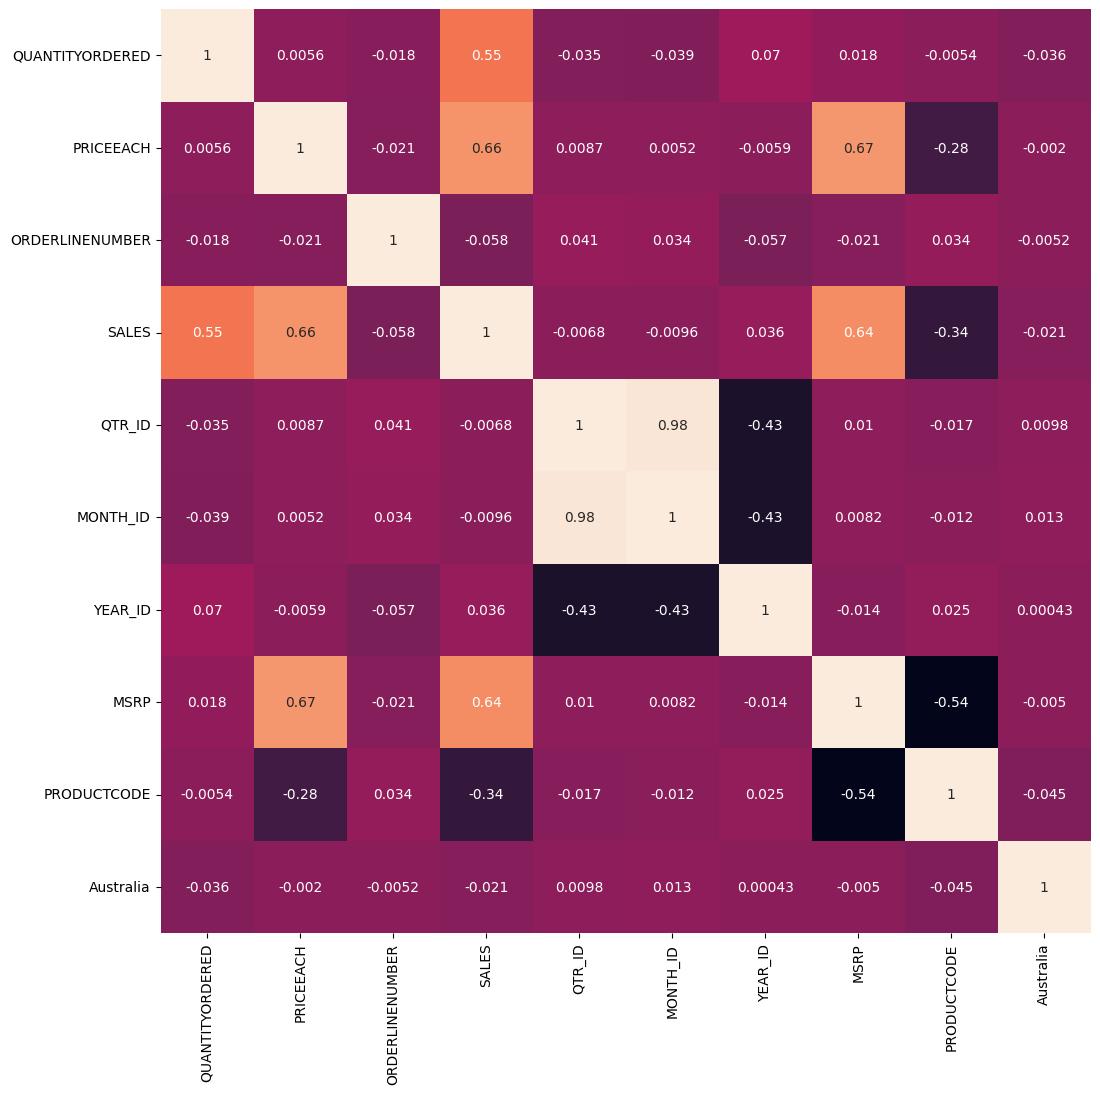

In [ ]:
plt.figure(figsize = (12, 12))
corr_matrix = sales_df.iloc[:, :10].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

In [ ]:
# It looks like the Quarter ID and the monthly IDs are highly correlated
# Let's drop 'QTR_ID' (or 'MONTH_ID')
sales_df.drop("QTR_ID", axis = 1, inplace = True)
sales_df.shape

(2823, 37)

In [ ]:
# Let's plot distplots
# Distplot shows the (1) histogram, (2) kde plot and (3) rug plot.
# (1) Histogram: it's a graphical display of data using bars with various heights. Each bar groups numbers into ranges and taller bars show that more data falls in that range.
# (2) Kde Plot: Kernel Density Estimate is used for visualizing the Probability Density of a continuous variable.
# (3) Rug plot: plot of data for a single quantitative variable, displayed as marks along an axis (one-dimensional scatter plot).

import plotly.figure_factory as ff

plt.figure(figsize = (10, 10))

for i in range(8):
  if sales_df.columns[i] != 'ORDERLINENUMBER':
    fig = ff.create_distplot([sales_df[sales_df.columns[i]].apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text = sales_df.columns[i])
    fig.show()

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# Visualize the relationship between variables using pairplots
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(sales_df,
    dimensions = sales_df.columns[:8], color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()

# A trend exists between 'SALES' and 'QUANTITYORDERED'
# A trend exists between 'MSRP' and 'PRICEEACH'
# A trend exists between 'PRICEEACH' and 'SALES'
# It seems that sales growth exists as we move from 2013 to 2014 to 2015 ('SALES' vs. 'YEAR_ID')
# zoom in into 'SALES' and 'QUANTITYORDERED', you will be able to see the monthly information color coded on the graph


<Figure size 1500x1500 with 0 Axes>

# finding no of clusters using Elbow Method

In [ ]:
#Scale the data
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

In [ ]:
sales_df_scaled.shape

(2823, 37)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

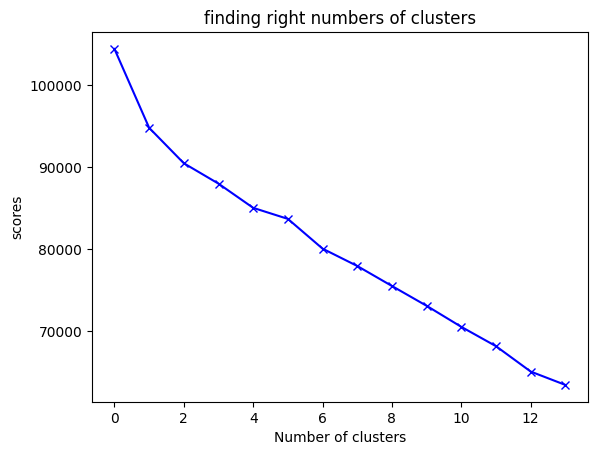

In [ ]:
scores = []

range_value  = range(1,15)

for i in range_value:
  kmeans= KMeans(n_clusters=i)
  kmeans.fit(sales_df_scaled)
  scores.append(kmeans.inertia_) # interita is the sum of sqared distances of samples to their closest clusters center

plt.plot(scores,'bx-')
plt.title('finding right numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('scores')
plt.show()

In [ ]:
kmeans = KMeans(5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
labels


array([2, 2, 1, ..., 3, 3, 3], dtype=int32)

In [ ]:
kmeans.cluster_centers_.shape

(5, 37)

In [ ]:
# Let's take a look at the cluster centers
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,-0.170181,0.120853,0.026106,0.034390,0.344773,-0.627006,0.115706,-0.151523,-0.264819,-0.140961,...,0.145864,0.147504,0.067603,-0.300637,-0.023001,-0.002404,-0.122466,0.014002,0.007720,-0.014196
1,0.276540,0.593064,-0.018919,0.477132,0.002617,0.007366,0.419366,-0.265481,0.013306,0.028933,...,0.148373,0.010558,-0.020494,-0.300637,-0.048149,0.095285,-0.014878,-0.242672,1.019676,-0.912100
2,-0.455699,-0.775805,0.037777,-0.823645,-0.003740,0.017333,-0.593140,0.190314,0.064394,-0.024370,...,-0.104929,0.052956,0.112087,-0.300637,0.107356,-0.003188,0.156510,-0.242672,-0.980703,1.096370
3,-0.037171,0.009763,0.078809,-0.271913,-0.043991,0.001642,-0.363043,1.126176,-0.230280,-0.017283,...,-0.721812,-0.364452,-0.348674,3.326275,-0.167454,-0.345470,-0.523371,-0.242672,-0.066000,0.177967
4,1.254287,0.799894,-0.259817,2.575383,-0.118863,0.160878,1.445643,-0.890508,-0.078720,0.049437,...,0.595197,0.003636,-0.158212,-0.300637,-0.127064,-0.217573,-0.155059,4.120788,-0.980703,-0.912100


In [ ]:
# In order to understand what these numbers mean, let's perform inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

# Cluster 0 (Highest) - This group represents customers who buy items in high quantity centered around ~47, they buy items in all price range leaning towards high price items of ~99. They also correspond to the highest total sales around ~8296 and they are active throughout the year. They are the highest buyers of products with high MSRP ~158.
# Cluster 1 - This group represents customers who buy items in varying quantity ~35, they tend to buy high price items ~96. Their sales is bit better average ~4435, they buy products with second highest MSRP of ~133.
# Cluster 2 (lowest) - This group represents customers who buy items in low quantity ~30. They tend to buy low price items ~68. Their sales ~2044 is lower than other clusters and they are extremely active around holiday season. They buy products with low MSRP ~75.
# Cluster 3 - This group represents customers who are only active during the holidays. they buy in lower quantity ~35, but they tend to buy average price items around ~86. They also correspond to lower total sales around ~3673, they tend to buy items with MSRP around 102.
# Cluster 4 - This group represents customers who buy items in varying quantity ~39, they tend to buy average price items ~94. Their sales ~4280.

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,33.435294,86.096235,6.576471,3617.220000,8.352941,2003.376471,105.364706,48.988235,1.387779e-17,-2.081668e-17,...,4.117647e-01,1.647059e-01,1.294118e-01,-6.938894e-17,2.352941e-02,1.058824e-01,1.647059e-01,5.882353e-02,4.941176e-01,4.470588e-01
1,37.786235,95.621053,6.386235,4432.546510,7.102024,2003.820243,117.565992,45.389474,6.882591e-02,2.348178e-02,...,4.129555e-01,1.206478e-01,1.020243e-01,-9.436896e-16,1.943320e-02,1.360324e-01,2.089069e-01,4.163336e-17,1.000000e+00,-7.660539e-15
2,30.654432,68.010009,6.625783,2037.114163,7.078782,2003.827216,76.882722,59.783348,8.146822e-02,1.611459e-02,...,2.927484e-01,1.342883e-01,1.432408e-01,-4.163336e-16,4.476276e-02,1.056401e-01,2.793196e-01,5.898060e-16,-1.054712e-15,1.000000e+00
3,34.730769,83.855470,6.799145,3053.150128,6.931624,2003.816239,86.128205,89.337607,8.547009e-03,1.709402e-02,...,1.665335e-16,-4.718448e-16,-2.775558e-17,1.000000e+00,-1.318390e-16,-2.775558e-17,4.996004e-16,-2.012279e-16,4.572650e-01,5.427350e-01
4,47.309211,99.792961,5.368421,8296.556316,6.657895,2003.927632,158.802632,25.651316,4.605263e-02,2.631579e-02,...,6.250000e-01,1.184211e-01,5.921053e-02,-9.714451e-17,6.578947e-03,3.947368e-02,1.513158e-01,1.000000e+00,-7.771561e-16,1.221245e-15


In [ ]:
labels.shape # Labels associated to each data pointa

(2823,)

In [ ]:
labels.max()

4

In [ ]:
labels.min()

0

In [ ]:
y_means = kmeans.fit_predict(sales_df_scaled)
y_means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([3, 3, 4, ..., 4, 3, 4], dtype=int32)

In [ ]:
# adding a label which clustewr corresponding to each data point
sale_df_cluster = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
sale_df_cluster

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,2
1,34,81.35,5,2765.90,5,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,2
2,41,94.74,2,3884.34,7,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,45,83.26,6,3746.70,8,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,1
4,49,100.00,14,5205.27,10,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108,0,0,...,0,0,1,0,0,0,0,0,1,3
2819,29,100.00,1,3978.51,1,2005,54,108,0,0,...,0,0,1,0,0,0,0,1,0,3
2820,43,100.00,4,5417.57,3,2005,54,108,0,0,...,0,0,1,0,0,0,0,1,0,3
2821,34,62.24,1,2116.16,3,2005,54,108,0,0,...,0,0,1,0,0,0,0,0,1,3


In [ ]:
sales_df['ORDERLINENUMBER'] = sales_df['ORDERLINENUMBER'].apply(lambda x : float(x))

In [ ]:
# plotting histogram based on each features in cluster

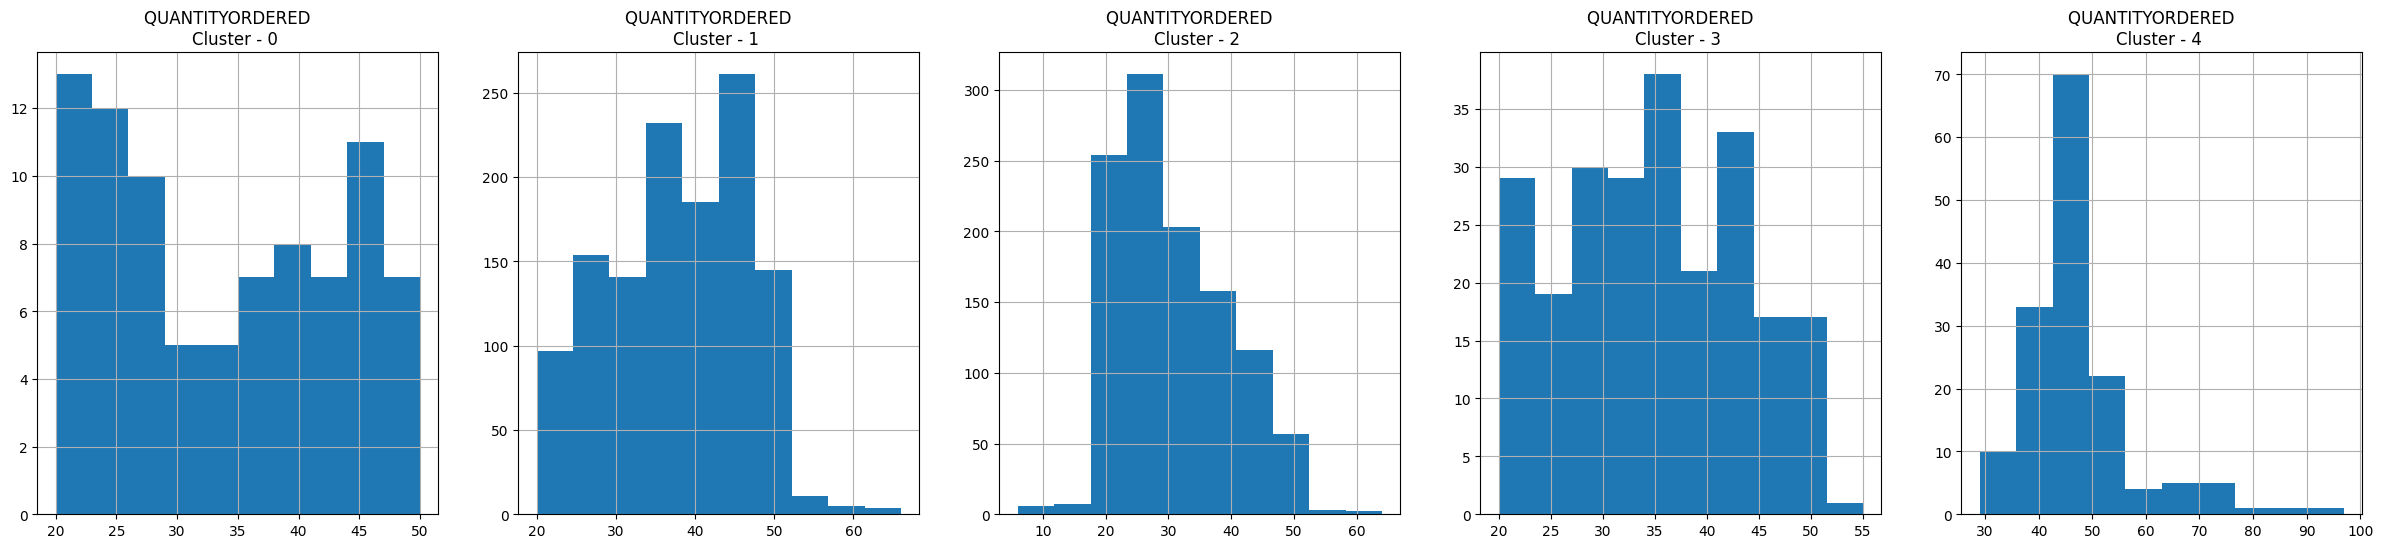

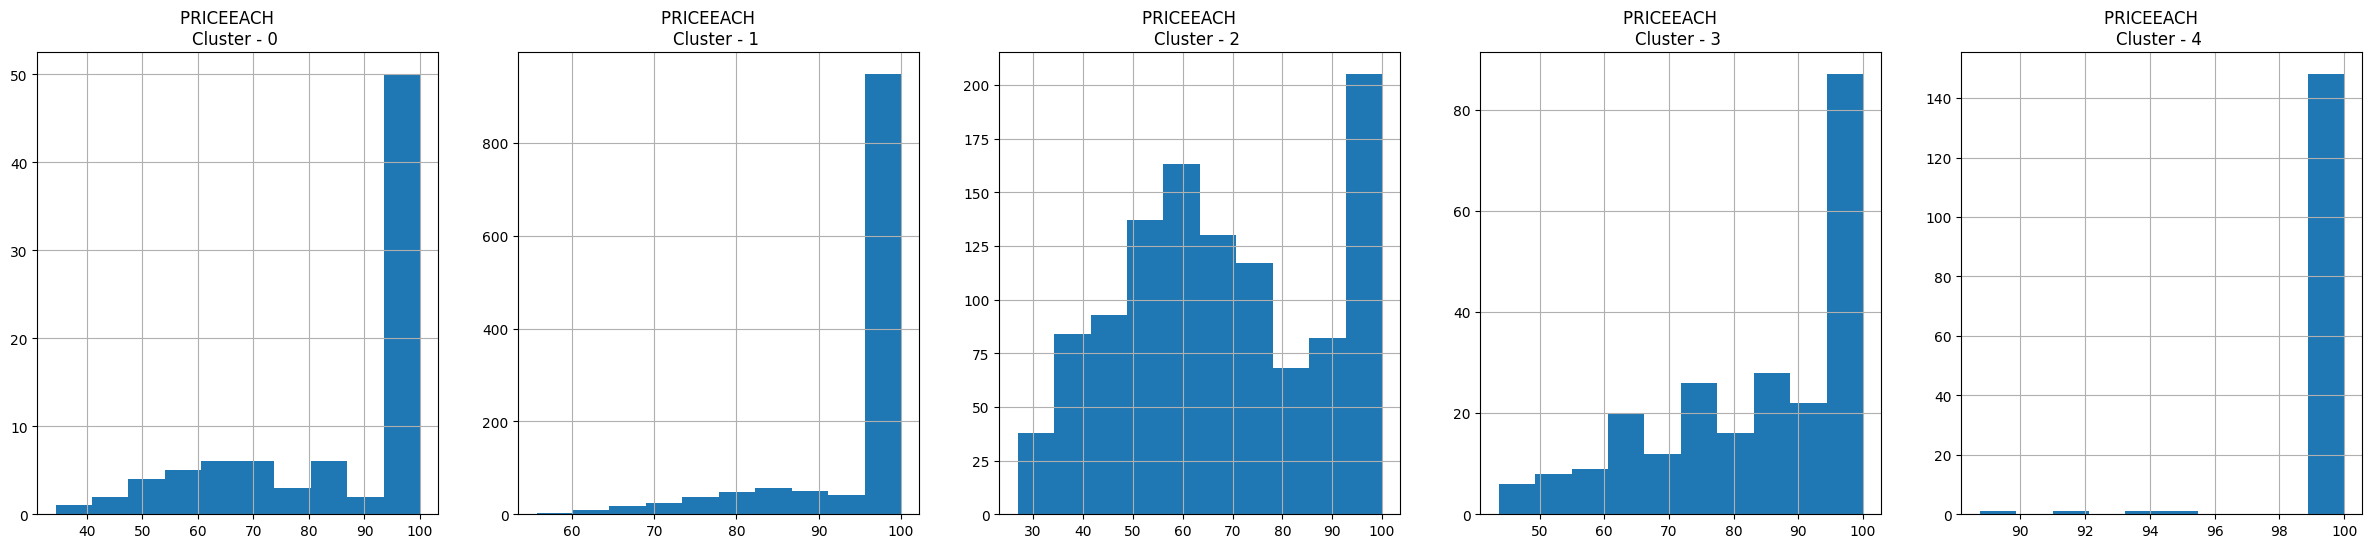

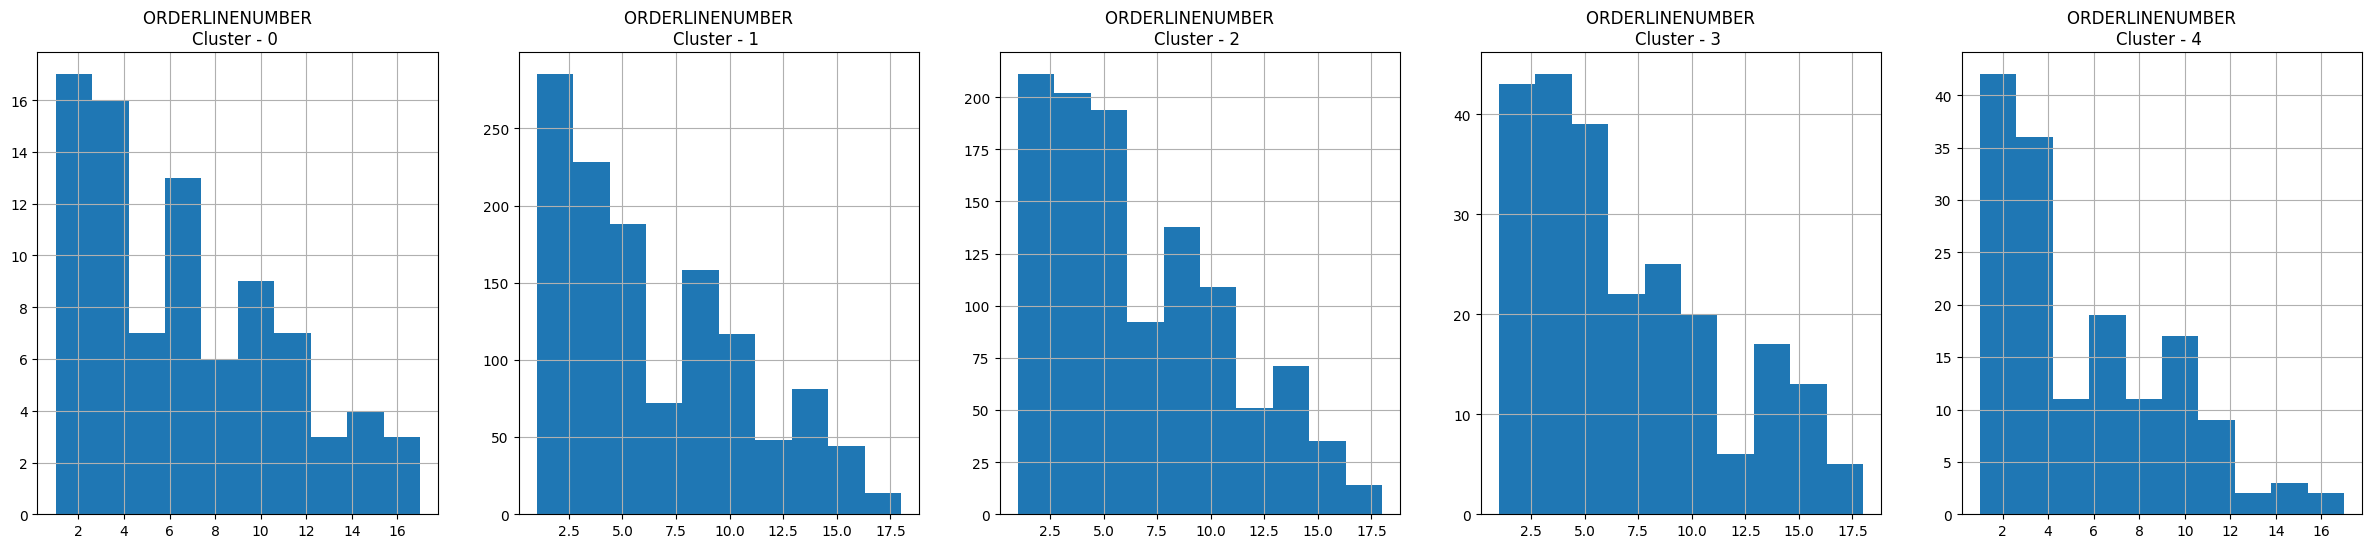

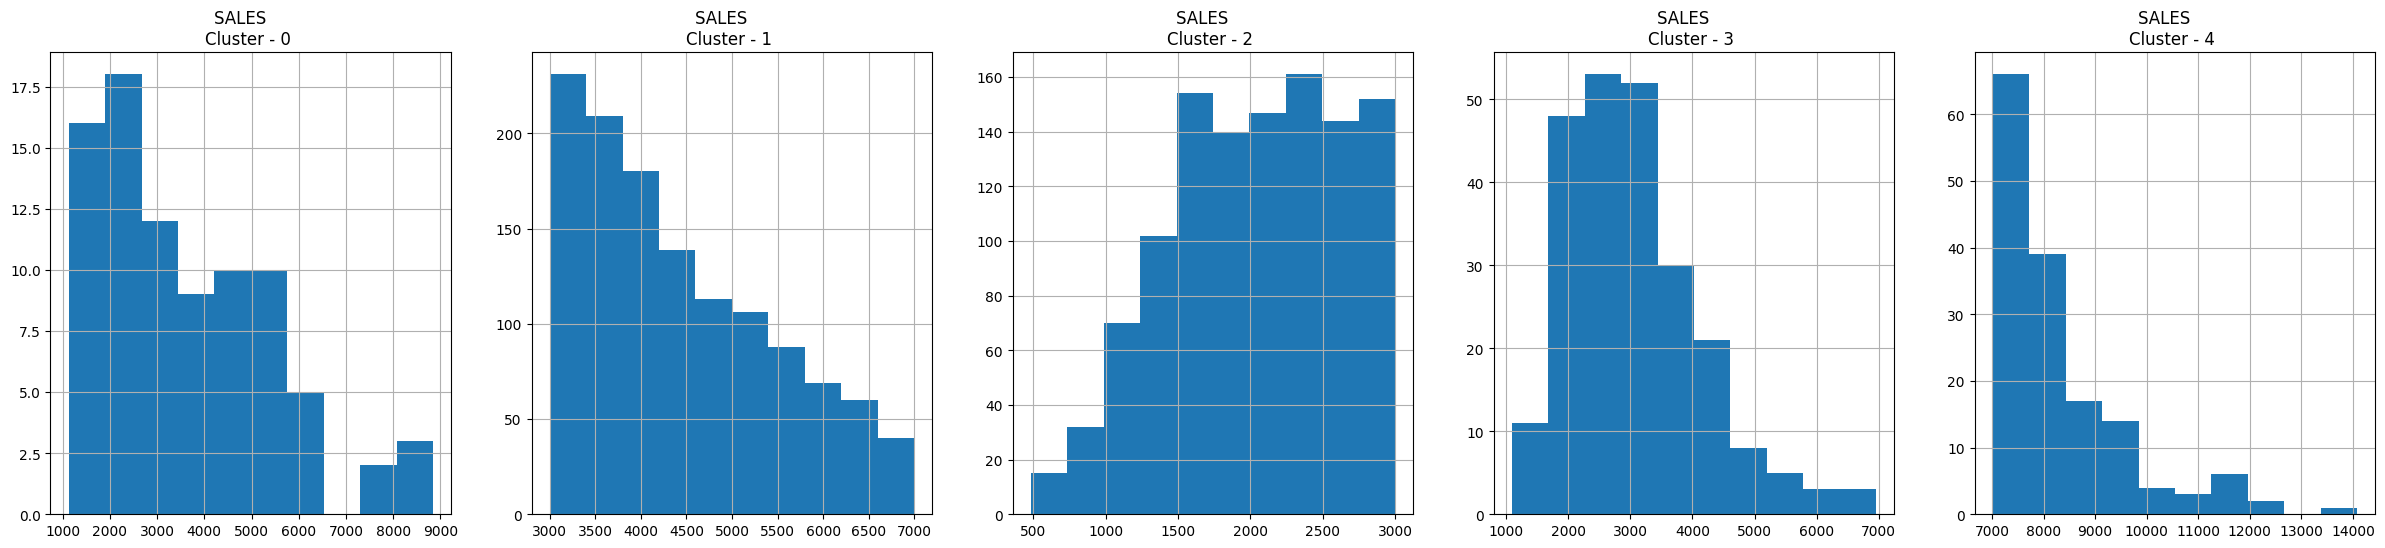

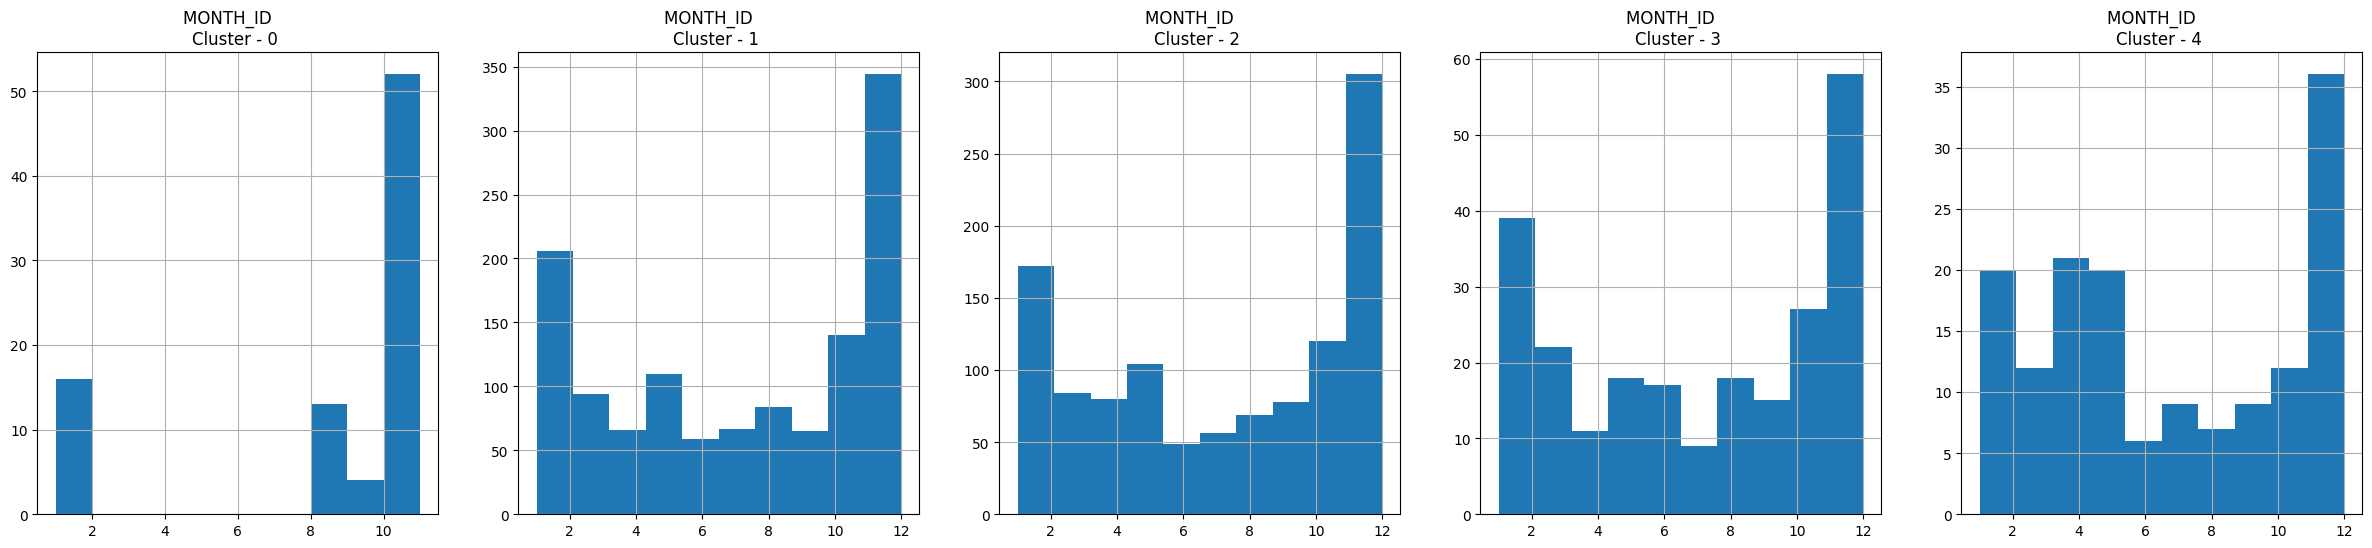

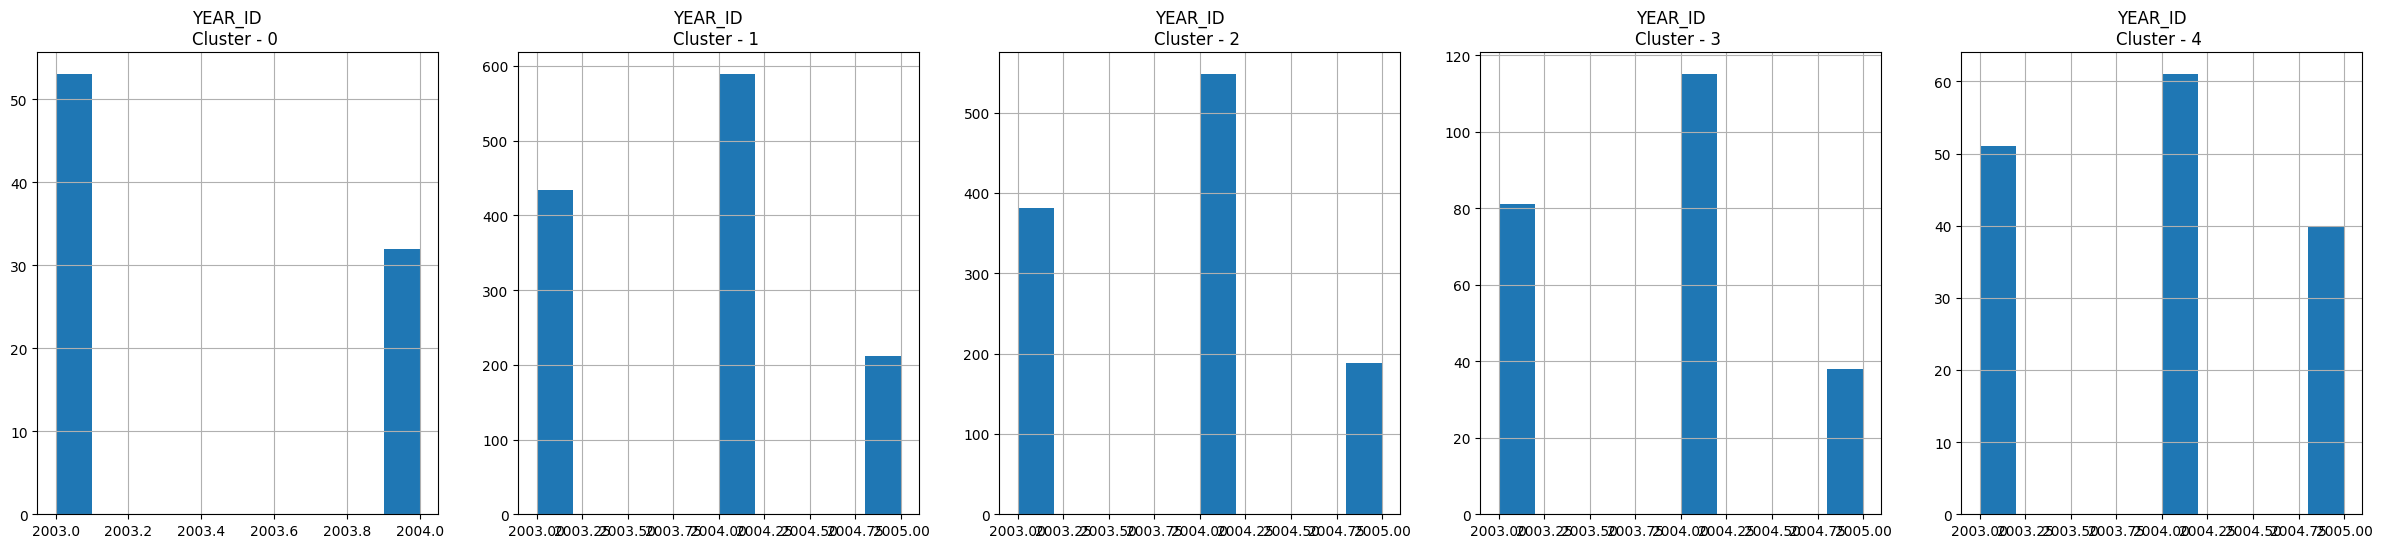

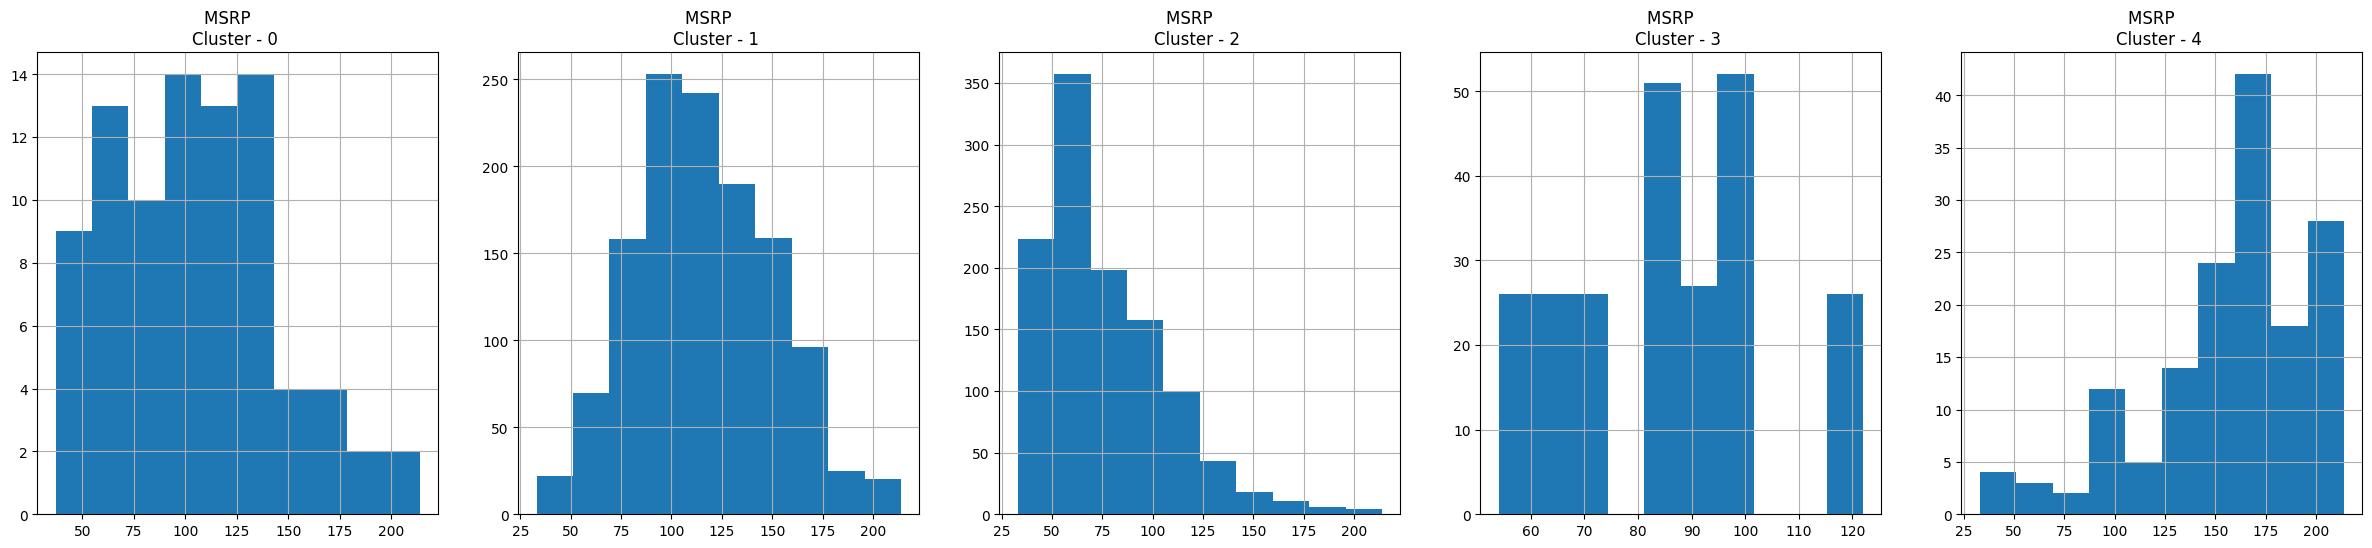

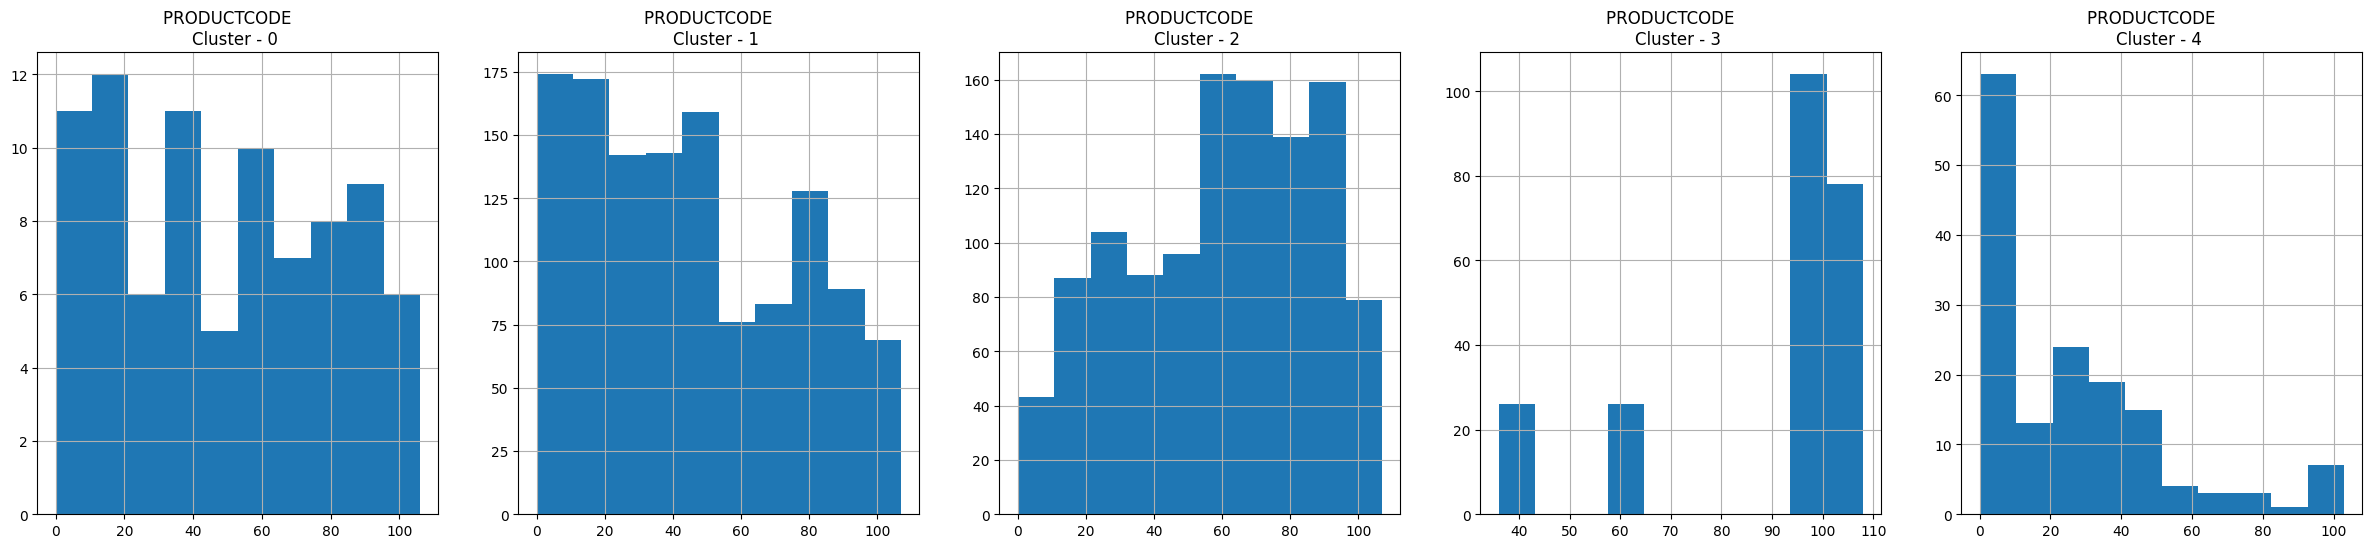

In [ ]:
# plot histogram for each feature based on cluster
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(5):
    plt.subplot(1, 5, j+1)
    cluster = sale_df_cluster[sale_df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))

  plt.show()


#APPLY PRINCIPAL COMPONENT ANALYSIS AND VISUALIZE THE RESULTS


In [ ]:
# Reduce the original data to 3 dimensions using PCA for visualizig the clusters
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.48633267, -1.21133983,  1.01506553],
       [-0.78467425, -1.09673284,  1.43243869],
       [ 1.43144049,  0.04903645,  0.30796346],
       ...,
       [ 0.3898785 ,  4.10888027, -0.08190149],
       [-2.78884111,  2.32737488,  1.56930966],
       [-0.70548477,  3.31538917, -0.53347157]])

In [ ]:
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2', 'pca2'])
pca_df.head()

,pca1,pca2,pca2
0,-0.486333,-1.211340,1.015066
1,-0.784674,-1.096733,1.432439
2,1.431440,0.049036,0.307963
3,1.288391,-0.233096,-0.574884
4,1.975981,-0.144539,-1.082892


In [ ]:
# Concatenate the clusters labels to the dataframe
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

,pca1,pca2,pca2,cluster
0,-0.486333,-1.211340,1.015066,2
1,-0.784674,-1.096733,1.432439,2
2,1.431440,0.049036,0.307963,1
3,1.288391,-0.233096,-0.574884,1
4,1.975981,-0.144539,-1.082892,1
...,...,...,...,...
2818,-2.450279,1.102645,-1.586682,3
2819,-0.158395,3.733532,0.658951,3
2820,0.389878,4.108880,-0.081901,3
2821,-2.788841,2.327375,1.569310,3


In [ ]:
import plotly.express as px

# Correct the column names
pca_df.columns = ['pca1', 'pca2', 'pca3', 'cluster']

# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x='pca1', y='pca2', z='pca3',
                    color='cluster',symbol = 'cluster', opacity=0.7)
fig.update_traces(marker=dict(size=2))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

# UNDERSTAND THE THEORY AND INTUITION BEHIND AUTOENCODERS

In [ ]:
sales_df.shape

(2823, 37)

In [ ]:
# from keras.optimizers import SGD

# Glorot Uniform initializer: https://keras.rstudio.com/reference/initializer_glorot_uniform.html

input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

# encoder - used for dimensionality reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [ ]:
autoencoder.fit(sales_df, sales_df, batch_size = 128, epochs = 500, verbose = 3)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [ ]:
autoencoder.save_weights('autoencoder_1.weights.h5')

In [ ]:
pred = encoder.predict(sales_df_scaled)

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

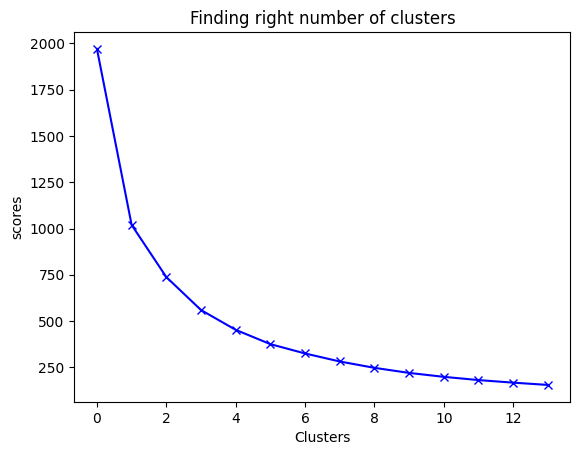

In [ ]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pred)
  scores.append(kmeans.inertia_)

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores')
plt.show()

In [ ]:
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(sales_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2.0,2871.00,2,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,2
1,34,81.35,5.0,2765.90,5,2003,95,0,0,0,...,1,0,0,0,0,0,0,0,1,2
2,41,94.74,2.0,3884.34,7,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,2
3,45,83.26,6.0,3746.70,8,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,1
4,49,100.00,14.0,5205.27,10,2003,95,0,0,0,...,1,0,0,0,0,0,0,1,0,2


In [ ]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,1.245428,0.800220,-0.259579,2.573861,-0.088008,0.136857,1.430265,-0.871802,-0.084647,0.043374,...,0.580097,0.011712,-0.164278,-0.300637,-0.128350,-0.201008,-0.151285,4.120788,-0.980703,-0.91210
1,-0.468912,-0.724370,0.043454,-0.810304,0.007142,-0.003285,-0.581757,0.285478,0.025174,-0.016801,...,-0.162957,0.013781,0.072858,0.058660,0.071986,-0.044714,0.087993,-0.242672,-0.980703,1.09637
2,0.293073,0.580208,-0.010805,0.458608,0.003368,-0.012482,0.376634,-0.165542,-0.013717,0.010642,...,0.085141,-0.014094,-0.048853,-0.020232,-0.052121,0.064221,-0.064346,-0.242672,1.019676,-0.91210


In [ ]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,47.222930,99.799554,5.369427,8293.753248,6.770701,2003.910828,158.184713,26.242038,0.044586,0.025478,...,0.617834,0.121019,0.057325,-1.110223e-16,0.006369,0.044586,0.152866,1.000000e+00,-8.326673e-16,9.992007e-16
1,30.525741,69.047496,6.649766,2061.682800,7.118565,2003.812793,77.340094,62.788612,0.071763,0.017161,...,0.265211,0.121685,0.131045,9.906396e-02,0.039002,0.092824,0.251170,-1.595946e-16,-1.110223e-15,1.000000e+00
2,37.947254,95.361741,6.420520,4398.433699,7.104769,2003.806358,115.848988,48.545520,0.062139,0.020954,...,0.382948,0.112717,0.093208,7.731214e-02,0.018786,0.126445,0.188584,-5.273559e-16,1.000000e+00,-8.715251e-15


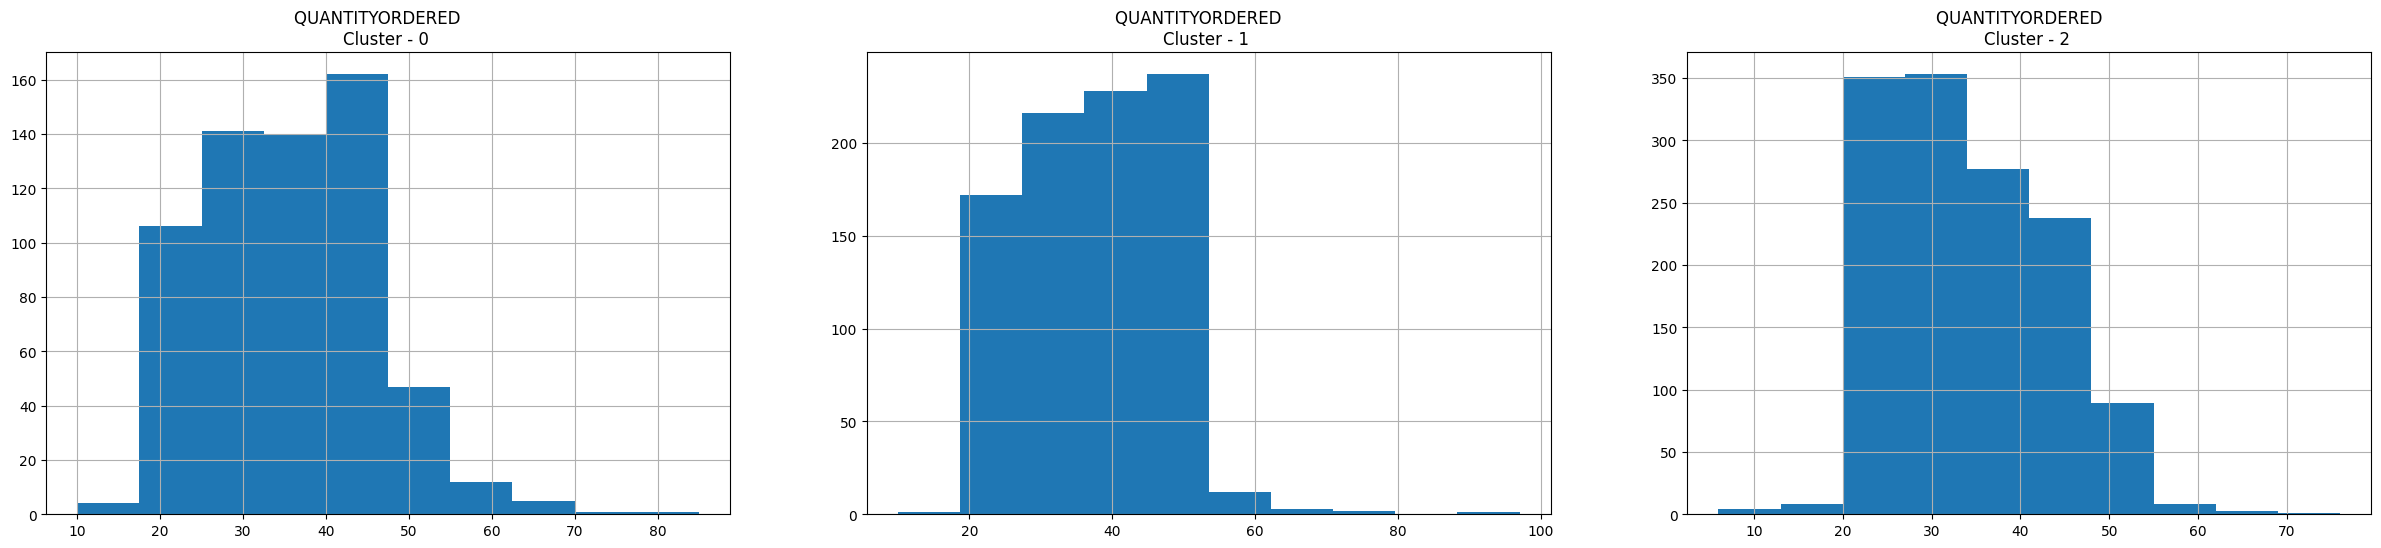

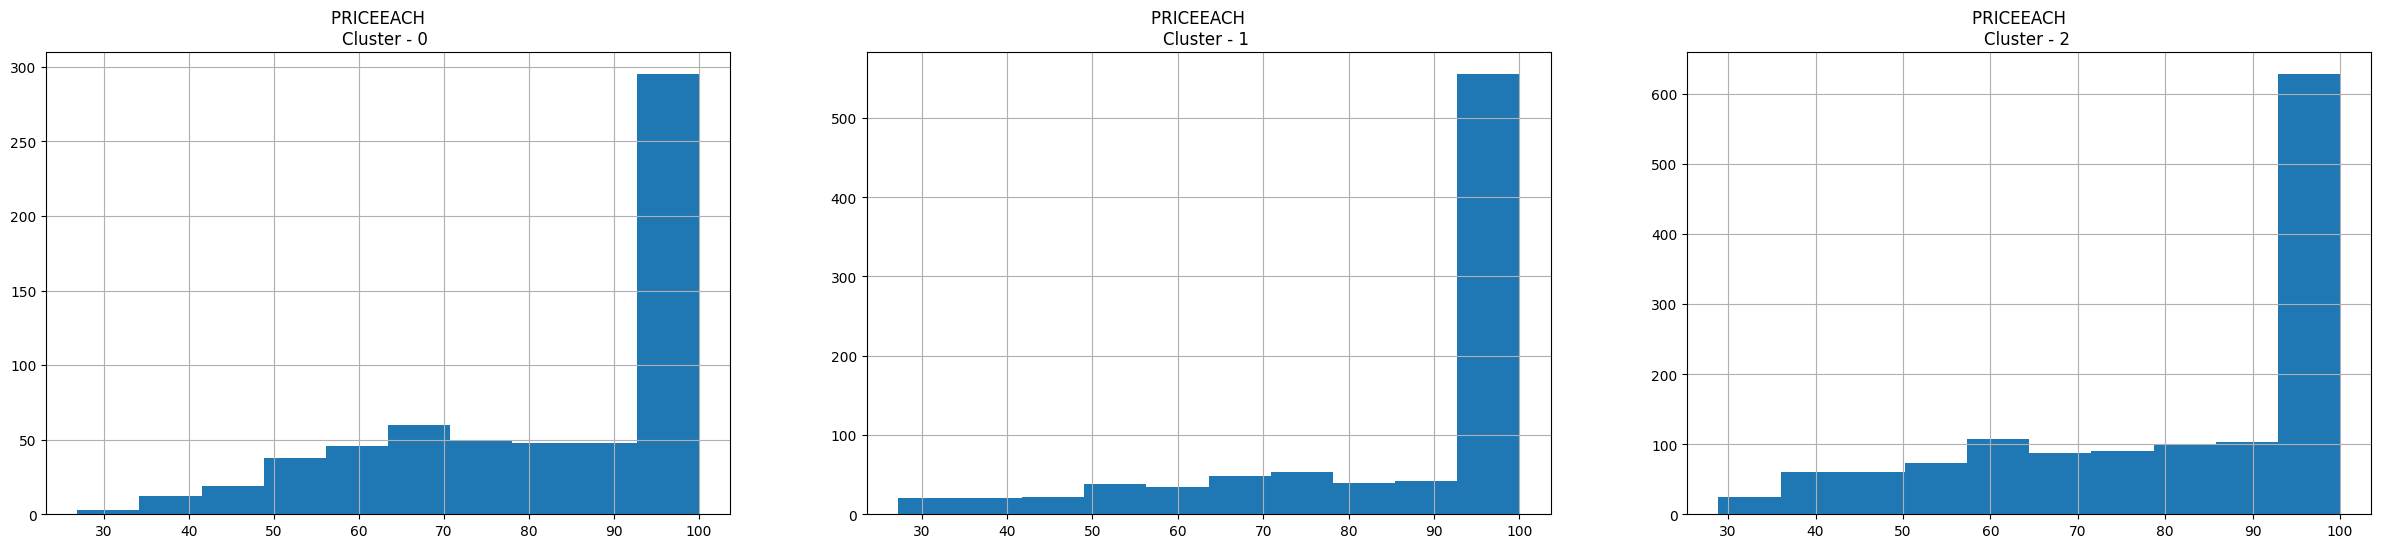

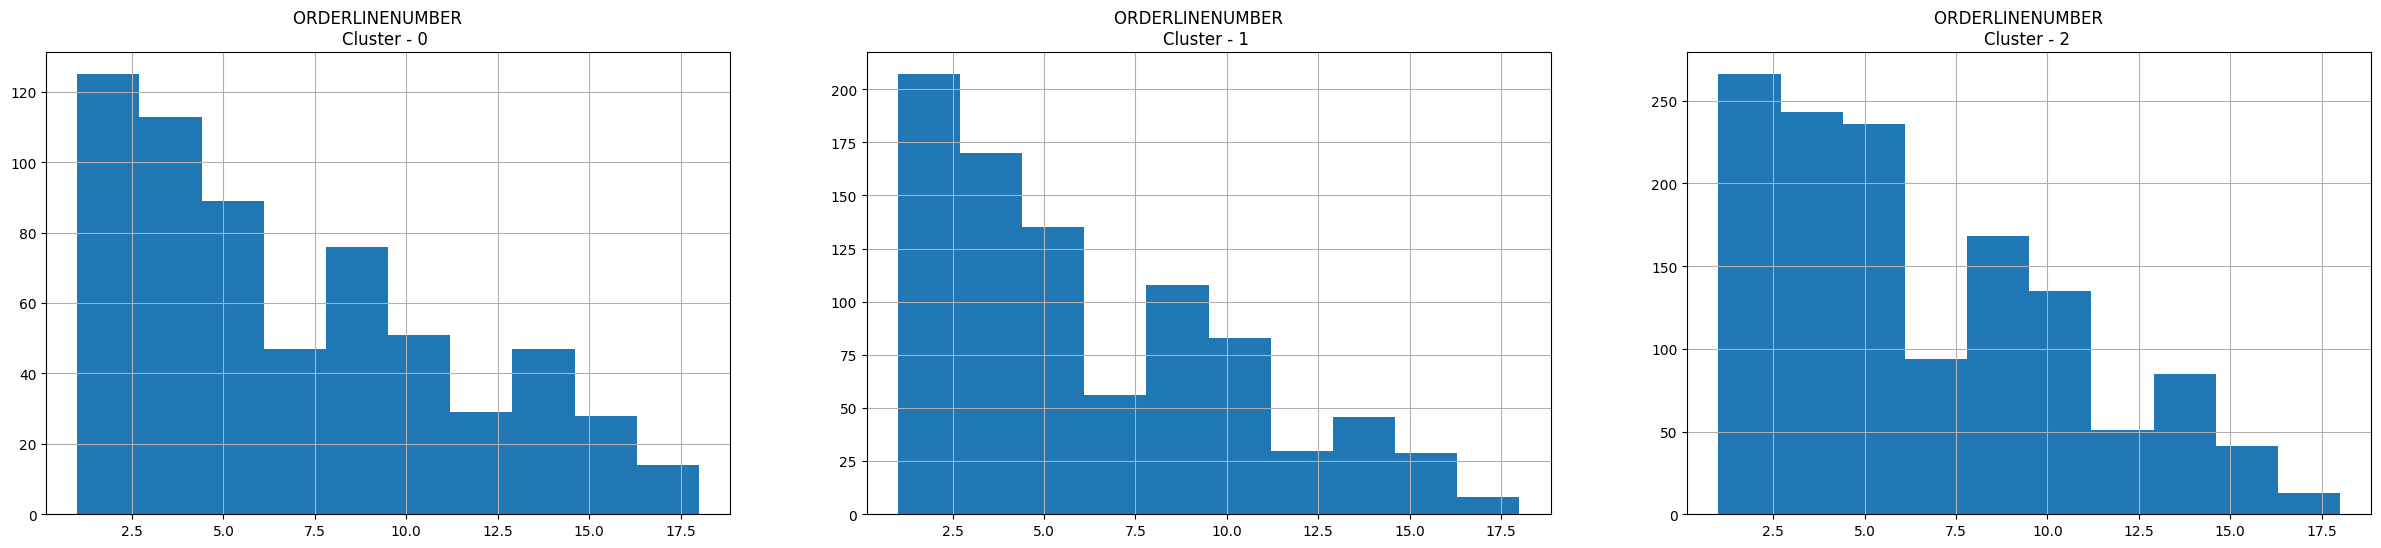

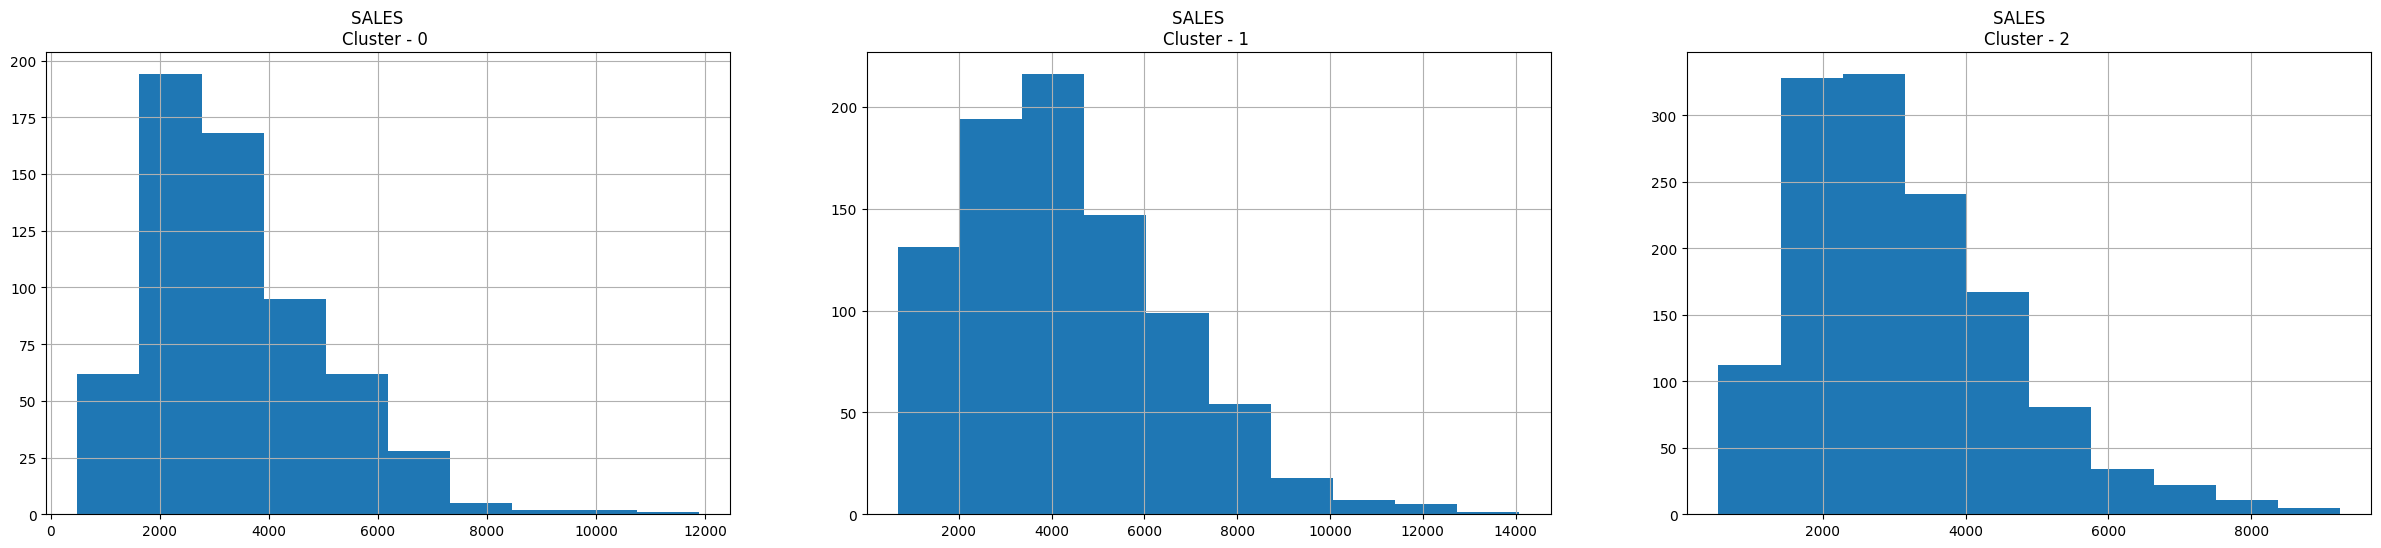

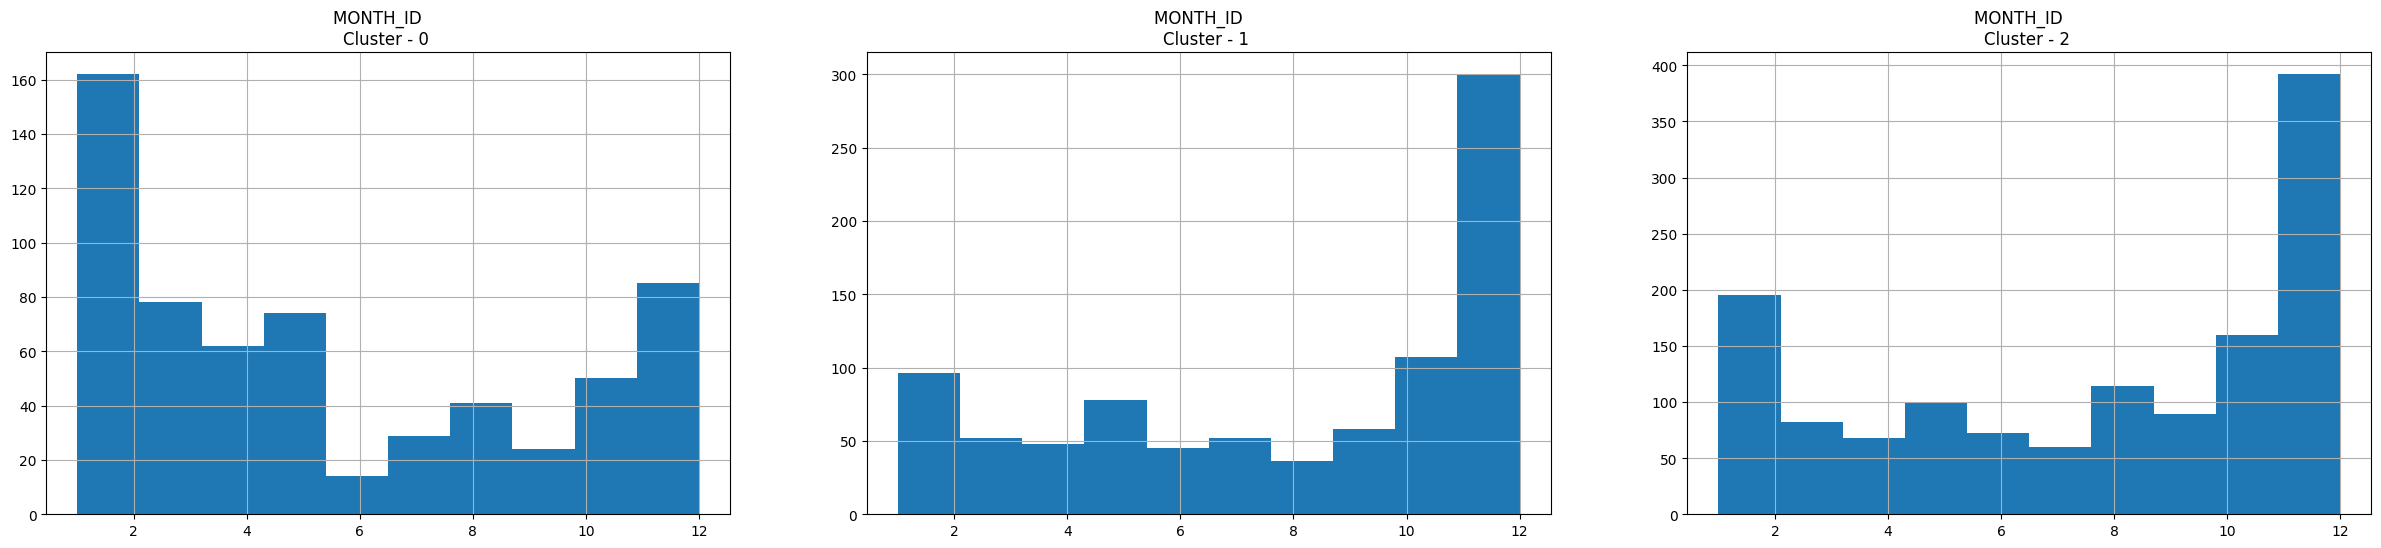

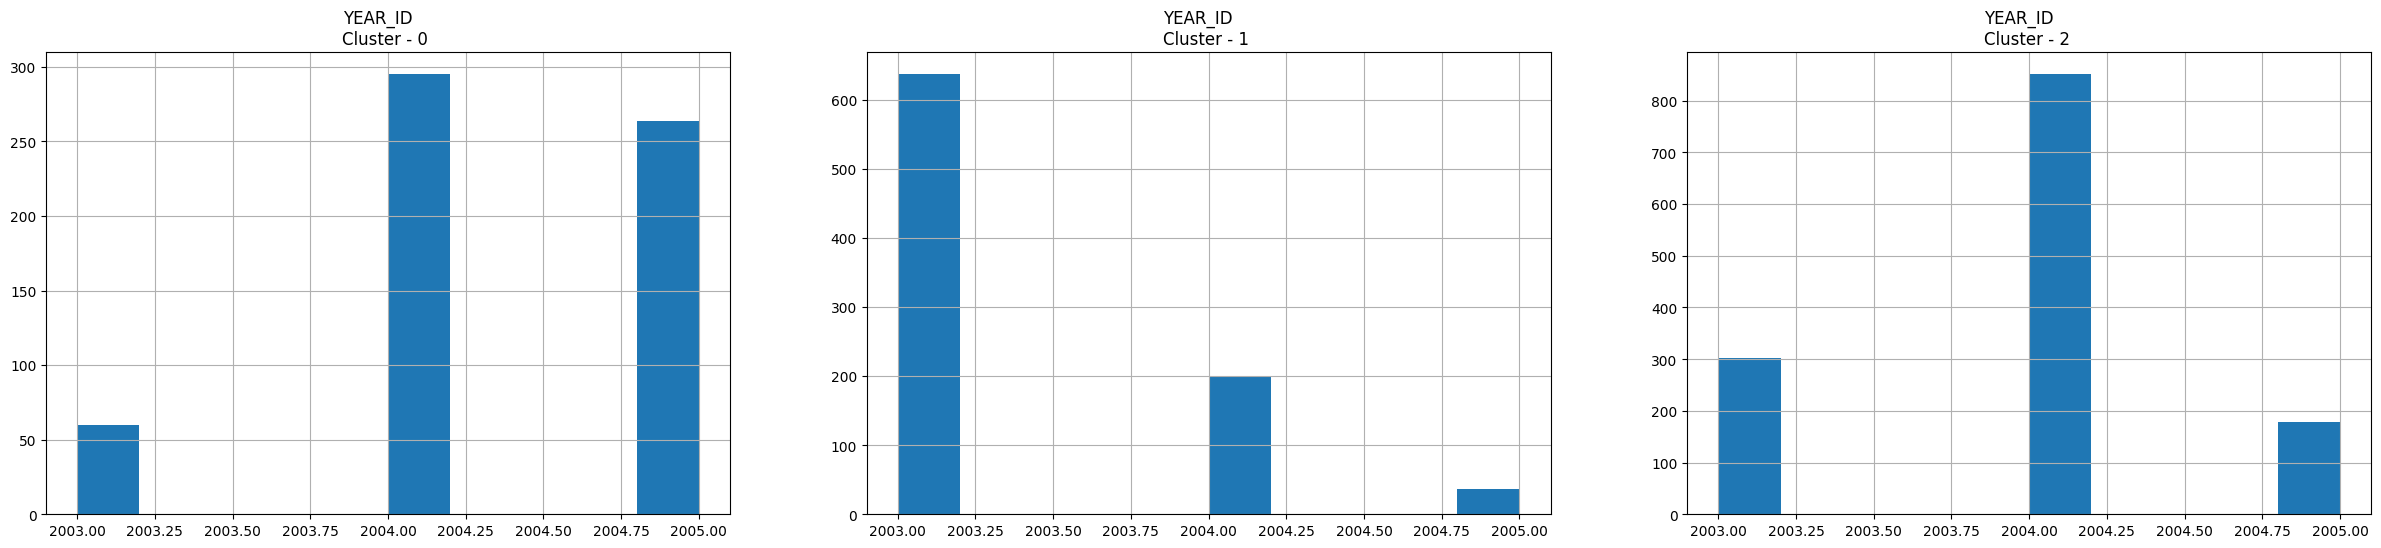

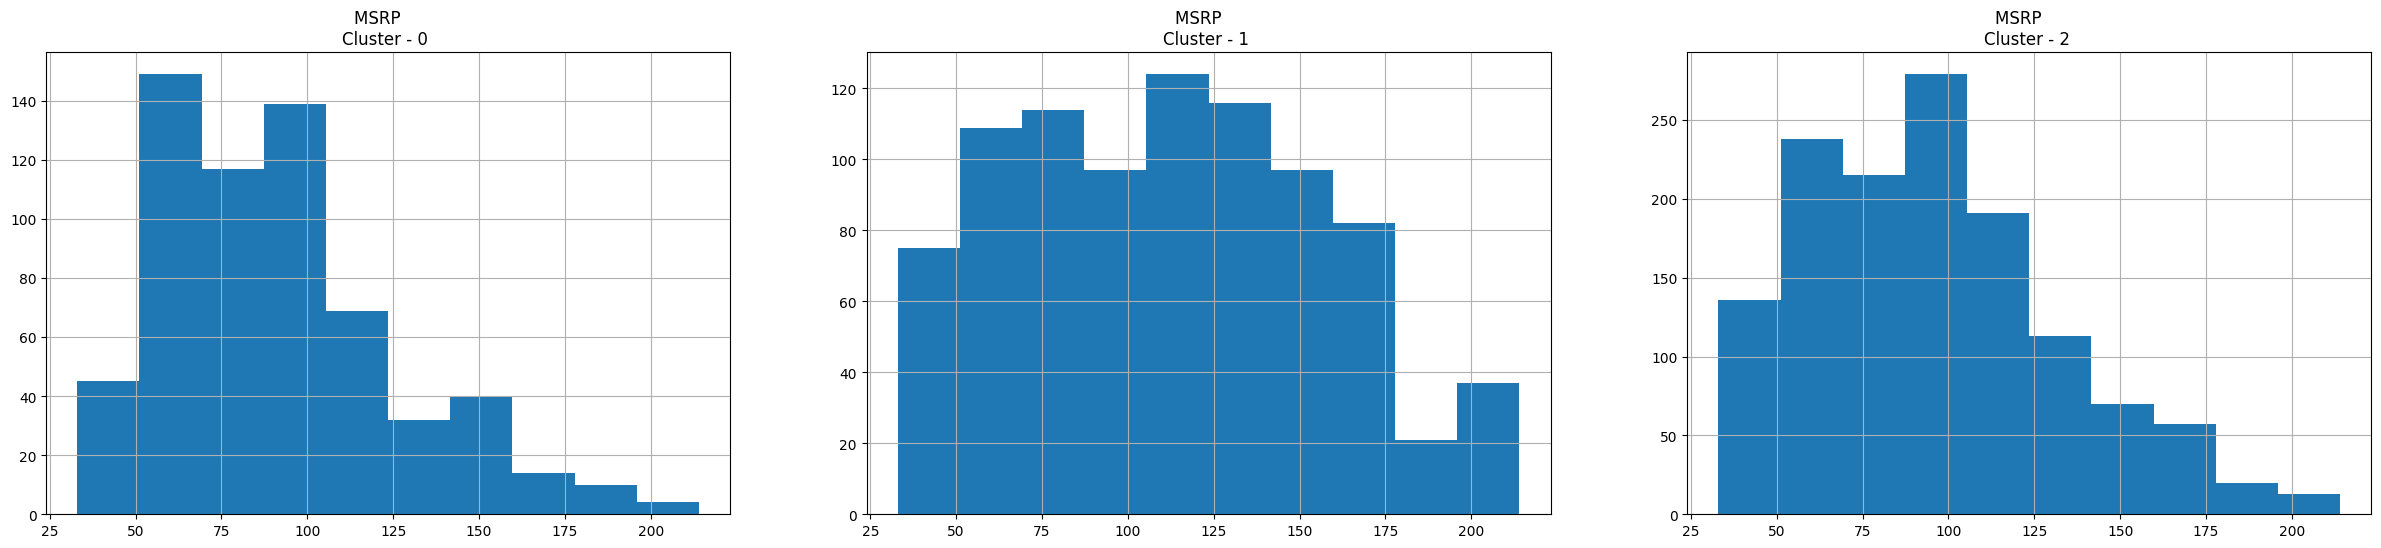

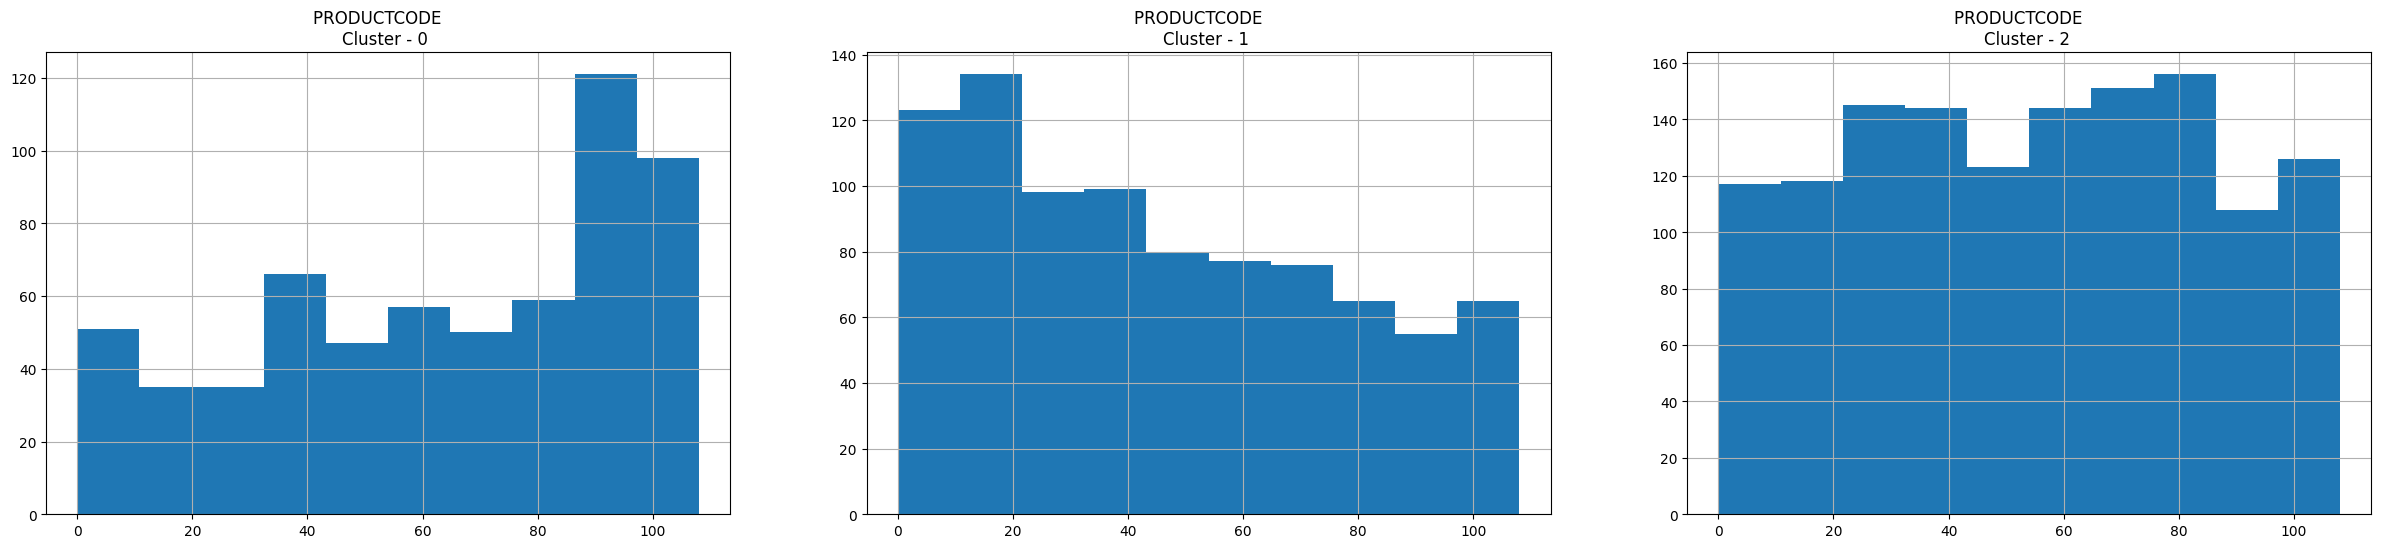

In [ ]:
# plot histogram for each feature based on cluster
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(3):
    plt.subplot(1, 3, j+1)
    cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))

  plt.show()


In [ ]:
# Cluster 0 - This group represents customers who buy items in high quantity(47), they usually buy items with high prices(99). They bring-in more sales than other clusters. They are mostly active through out the year. They usually buy products corresponding to product code 10-90. They buy products with high mrsp(158).
# Cluster 1 - This group represents customers who buy items in average quantity(37) and they buy tend to buy high price items(95). They bring-in average sales(4398) and they are active all around the year.They are the highest buyers of products corresponding to product code 0-10 and 90-100.Also they prefer to buy products with high MSRP(115) .
# Cluster 2 - This group represents customers who buy items in small quantity(30), they tend to buy low price items(69). They correspond to the lowest total sale(2061) and they are active all around the year.They are the highest buyers of products corresponding to product code 0-20 and 100-110  they then to buy products with low MSRP(77).

In [ ]:
# Reduce the original data to 3 dimension using PCA for visualize the clusters
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-0.486294,-1.210726,0.979048
1,-0.784757,-1.029864,1.431740
2,1.431303,0.138182,0.333499
3,1.288406,-0.215493,-0.587317
4,1.976045,-0.143311,-1.102755


In [ ]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,-0.486294,-1.210726,0.979048,2
1,-0.784757,-1.029864,1.431740,2
2,1.431303,0.138182,0.333499,2
3,1.288406,-0.215493,-0.587317,1
4,1.976045,-0.143311,-1.102755,2


In [ ]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color='cluster', symbol = 'cluster', size_max = 3, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

In [ ]:
# Check the number of non-null values in the dataframe
sales_df.info()

# Check the number of Null values in the data
sales_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   QUANTITYORDERED   2823 non-null   int64  
 1   PRICEEACH         2823 non-null   float64
 2   ORDERLINENUMBER   2823 non-null   float64
 3   SALES             2823 non-null   float64
 4   MONTH_ID          2823 non-null   int64  
 5   YEAR_ID           2823 non-null   int64  
 6   MSRP              2823 non-null   int64  
 7   PRODUCTCODE       2823 non-null   int8   
 8   Australia         2823 non-null   int64  
 9   Austria           2823 non-null   int64  
 10  Belgium           2823 non-null   int64  
 11  Canada            2823 non-null   int64  
 12  Denmark           2823 non-null   int64  
 13  Finland           2823 non-null   int64  
 14  France            2823 non-null   int64  
 15  Germany           2823 non-null   int64  
 16  Ireland           2823 non-null   int64  


,0
QUANTITYORDERED,0
PRICEEACH,0
ORDERLINENUMBER,0
SALES,0
MONTH_ID,0
YEAR_ID,0
MSRP,0
PRODUCTCODE,0
Australia,0
Austria,0


In [ ]:
sales_df.columns

Index(['QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'MONTH_ID',
       'YEAR_ID', 'MSRP', 'PRODUCTCODE', 'Australia', 'Austria', 'Belgium',
       'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Ireland', 'Italy',
       'Japan', 'Norway', 'Philippines', 'Singapore', 'Spain', 'Sweden',
       'Switzerland', 'UK', 'USA', 'Classic Cars', 'Motorcycles', 'Planes',
       'Ships', 'Trains', 'Trucks and Buses', 'Vintage Cars', 'Large',
       'Medium', 'Small'],
      dtype='object')

In [ ]:
# Obtain the number of unique values in each column
sales_df.nunique()

,0
QUANTITYORDERED,58
PRICEEACH,1016
ORDERLINENUMBER,18
SALES,2763
MONTH_ID,12
YEAR_ID,3
MSRP,80
PRODUCTCODE,109
Australia,2
Austria,2
